## Theoretical part

<b>1a)</b>
P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$)

This probability of an experiment lacking the power to reject $H_0$ is ($1 -\alpha  $) so the probability that it gets rejected is $\alpha$. Assuming that consecutive experiments are  independent, the probability that the $m^{th}$ experiment gives significant result is: 

$(1-\alpha)^{m-1}\alpha$

<b>1b)</b> 
P(at least one significant result | m experiments lacking power to reject $H_0$)

This probability is given by: 1$-$ P(no significant results | m experiments lacking power to reject $H_0$).
This then equals:

$
1 - (1 - \alpha  )^{m}  
$

<b>2)</b> 

Suppose we have the following two lists that we want to interleave based on team-draft interleaving.

RankA
1 2 4

RankB
2 3 4

Suppose 1 and 2 are clicked on 48% of the times, and 3 is clicked on 4% of the times. This means that the total clicks odds for RankA is 96% and 52% for RankB. Therefore RankA is the best algorithm.

The coin tosses and interleaved lists are given below

$\textbf{AA}$

1A 2B 4A (A wins 50% of the time)


$\textbf{AB}$

1A 2B 3B (A wins 48% of the time)


$\textbf{BA}$

2B 1A 4A (A wins 50% of the time)


$\textbf{BB}$

2B 1A 3B (A wins 48% of the time)

As B wins more often on average, this means that the team draft interleaving is unfair to the better algorithm in this specific case.


## Experimental part

## Step 1: Simulate Rankings of Relevance for E and P (5 points)

In the next section, we first create a list of all combinations of relevances. We use itertools.product which gives all possible combinations of a list in any order. Then we use permutation which gives all the combinations of experiment and production relevances. We use itertools.permutations to do this. This means there are no duplicate results in combinations (same E-relevances as P-relevances).

In [1]:
import itertools
values = ['N','R','HR'] #possible values of a prediction

relevances = [] #relevances contains all combinations of N/R/HR with length 5
for r in itertools.product(values, repeat=5):
    relevances.append(list(r))
print(relevances[:10]) #print first 10 relevance combinations

[['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'N', 'R'], ['N', 'N', 'N', 'N', 'HR'], ['N', 'N', 'N', 'R', 'N'], ['N', 'N', 'N', 'R', 'R'], ['N', 'N', 'N', 'R', 'HR'], ['N', 'N', 'N', 'HR', 'N'], ['N', 'N', 'N', 'HR', 'R'], ['N', 'N', 'N', 'HR', 'HR'], ['N', 'N', 'R', 'N', 'N']]


In [2]:
combinations = [] #combinations contains all pairs of relevances
for p in itertools.permutations(relevances, 2):
    combinations.append(list(p)) #we use this to get rid of the permutations object

In [3]:
print(combinations[:10]) #show the first 10 permutations

[[['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'N', 'R']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'N', 'HR']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'R', 'N']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'R', 'R']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'R', 'HR']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'HR', 'N']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'HR', 'R']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'N', 'HR', 'HR']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'R', 'N', 'N']], [['N', 'N', 'N', 'N', 'N'], ['N', 'N', 'R', 'N', 'R']]]


## Step 2: Implement Evaluation Measures (10 points)

In the next section we take two assumptions:

1) Value mapping for the prediction relevances are N=0, R=1, HR=2.

2) The amount of relevant predictions (overall) is assumed to be the total amount of relevant (R or HR) docs in the prediction set. So we assume there is no overlap between articles in the predictions of E/P.

In [4]:
#the first binary evaluation methods: average precision
numeric_map = {'N':0, 'R':1, 'HR':2} #we use this numeric map to map N/R/HR to a numeric value.
prediction = ['R','HR','N','R','N'] #this is a sample prediction to test functions

def count_rel(prediction1,prediction2): #this function counts the total amount of relevant docs in both results.
    return sum(1 for i in prediction1 if i != 'N') + sum(1 for i in prediction2 if i != 'N')

def average_precision(prediction, r):
    ap = 0
    relevant_preds = 0
    for i in range(0,len(prediction)): #for every element of the prediction
        if prediction[i] != 'N': #if it is a relevant one
            relevant_preds += 1 #add one to the cumulative relevant documents
            ap += relevant_preds/(i+1) #calculate precision cumulative
    return ap/r #take the average.

ap = average_precision(prediction, count_rel(prediction, prediction))
print(ap)

0.4583333333333333


Now we will implement both multi-graded evaluation methods. 

The first is nDCG@k which requires a optimal prediction to normalize predictions. Here we will use the total amount of HR/R files to create an optimum prediction. Again we assume there is no overlap in predictions.

In [5]:
#nDCG@K
import numpy as np #numpy is amazing right?

def generate_opt(prediction1, prediction2): #generate optimal sequences from two predictions
    opt_pred = []
    num_hr = sum(1 for i in prediction1 if i == 'HR') + sum(1 for i in prediction2 if i == 'HR')
    num_r  = sum(1 for i in prediction1 if i == 'R') + sum(1 for i in prediction2 if i == 'R')
    for i in range(min(num_hr,5)): #check if num_hr exceeds 5, fill with HR's
        opt_pred.append('HR')
    for i in range(min(5-num_hr,num_r)): #check if num_r exceeds the space left, will with R's
        opt_pred.append('R')
    for i in range(5-len(opt_pred)): #fill the rest with N
        opt_pred.append('N')
    return opt_pred

def dcg_k(numeric_map, prediction, opt_pred, k):
    dcg_opt = 0
    dcg = 0
    for i in range(0,k): #for the range until K, we sum both the optimum and prediction dcg
        dcg_opt += (2**numeric_map[opt_pred[i]]-1)/np.log2(1+i+1)
        dcg +=(2**numeric_map[prediction[i]]-1)/np.log2(1+i+1)
    return dcg/dcg_opt #dcg is normalized compared to the optimum
ndcg = dcg_k(numeric_map, prediction, generate_opt(prediction,prediction), 3) #K=3 is used in this example
print(ndcg)

0.53641800576


The second one is ERR, this model does not need any assumptions.

In [6]:
#ERR
def ERR(numeric_map, prediction):
    err = 0
    max_val = 2**max(list(numeric_map.values())) #we calculate the maximum possible value from numeric mapping.
    thetas = [(2**numeric_map[p]-1)/max_val for p in prediction] #for every prediction, we estimate theta value
    for i in range(0,len(prediction)):
        pred_val = 1 #we start with 1 as we want to do cumulative multiplication
        for j in range(0,i): #loop back over earlier predictions
            pred_val *= (1-thetas[j])*thetas[i] 
        pred_val *= 1/(i+1)
        err += pred_val #add all values of individual predictions
    return err
err = ERR(numeric_map, prediction)
print(err)

1.281982421875


## Step 3: Calculate the 𝛥measure (0 points)

In [7]:
#Here we calculate the delta measure for the three offline performance measures. We know that this function returns a lot of information,
#however we need all this for different statistical analyses.
import math
def check_performance(combinations,printLog=True):
    #Here we initialize the counters for statistics
    ap_counter = 0
    ap_tie_counter = 0
    ap_delta = []
    total_ap_e = []
    total_ap_p = []
    err_counter = 0
    err_tie_counter = 0
    err_delta = []
    total_err_e = []
    total_err_p = []
    ndcg_counter = 0
    ndcg_tie_counter = 0
    ndcg_delta = []
    total_ndcg_e = []
    total_ndcg_p = []
    return_list = []
    all_delta_ap = []
    all_delta_err = []
    all_delta_ndcg = []
    total_count = len(combinations) #total amount of combinations we want to loop over
    k = 5 #K is used for nDCG@K
    for s in combinations:
        prediction_e = s[0] #split the predictions
        prediction_p = s[1]

        r = count_rel(prediction_e, prediction_p) #count relevant docs for both predictions
        ap_e, ap_p = average_precision(prediction_e, r), average_precision(prediction_p, r) #calculate ap
        if ap_e > ap_p: #we only want to look at cases where e>p
            ap_counter += 1
            ap_delta.append(ap_e-ap_p) #we append the difference between e and p.

        all_delta_ap.append(ap_e-ap_p)
        if ap_e == ap_p: #we also want to track ties
            ap_tie_counter += 1
        total_ap_e.append(ap_e)
        total_ap_p.append(ap_p)


        ERR_e, ERR_p = ERR(numeric_map, prediction_e), ERR(numeric_map, prediction_p) #calculate ERR scores
        if ERR_e > ERR_p: #same as before
            err_counter += 1
            err_delta.append(ERR_e-ERR_p)
        all_delta_err.append(ERR_e-ERR_p)
        if ERR_e == ERR_p:
            err_tie_counter += 1
        total_err_e.append(ERR_e)
        total_err_p.append(ERR_p)


        opt_prediction = generate_opt(prediction_e,prediction_p) #first we need the optimal prediction for normalization
        ndcg_e = dcg_k(numeric_map, prediction_e, opt_prediction, k) #calculate scoring for e
        ndcg_p = dcg_k(numeric_map, prediction_p, opt_prediction, k) #calculate scoring for p
        if ndcg_e > ndcg_p: #same as before
            ndcg_counter += 1
            ndcg_delta.append(ndcg_e-ndcg_p)
        all_delta_ndcg.append(ndcg_e-ndcg_p)
        if ndcg_e == ndcg_p:
            ndcg_tie_counter += 1
        total_ndcg_e.append(ndcg_e)
        total_ndcg_p.append(ndcg_p)


        return_list.append([(ap_e-ap_p),(ERR_e-ERR_p),(ndcg_e-ndcg_p)])

    if printLog == True:
        print("Percentage of cases that E outperforms P with average precision measure:",round((ap_counter/total_count),2), " and percentage of ties is: ",round((ap_tie_counter/total_count),2))
        print("Percentage of cases that E outperforms P with ERR measure:",round((err_counter/total_count),2),"and percentage of ties is: ",round((err_tie_counter/total_count),2))
        print("Percentage of cases that E outperforms P with NDCG measure:",round((ndcg_counter/total_count),2),"and percentage of ties is: ",round((ndcg_tie_counter/total_count),2))

    return ap_delta,err_delta,ndcg_delta,total_ap_e,total_ap_p,total_err_e,total_err_p,total_ndcg_e,total_ndcg_p,return_list,all_delta_ap,all_delta_err,all_delta_ndcg


## Step 4: Implement Interleaving (15 points)
We implemented both team based and balanced interleaving as this allows us to get a better insight in bias of both techniques. This will be discussed in the conclusion.

In [8]:
import copy

def get_A_first(): #This is a function that determines is ranking A goes first or not
    A = np.random.uniform() # Take a random uniform number between 0 and 1    
    if A > 0.5: 
        return True
    else: 
        return False
    
def balanced_interleaving(s, cutoff = False):
    
    ranking_A = s[0]
    ranking_B = s[1]
    
    # Initialize
    I = []
    k_a, k_b = 0,0
        
    A_first = get_A_first() #Find out if A or B goes first
    
    # We assume that rankA and rankB contain 10 unique documents
    # That is why we can cast rankA and rankB to a dict
    # This makes it easier to return a list of length 9, while adhering to the pseudo code from the slides
    
    rankA = {}
    rankB = {}
    
    A = [i for i in range(0,5)]
    B = [i for i in range(5,10)]
    
    for i in A:
        rankA[i] = ranking_A[i]
        
    for j in B:
        rankB[j] = ranking_B[j-5] 
        
    # This code just follows the pseudo code from the slides
    while k_a+1 <= len(ranking_A) and k_b+1 <= len(ranking_B):
        if (k_a < k_b) or ((k_a == k_b) and A_first):
            if A[k_a] not in I:
                I.append(A[k_a])
            k_a += 1
            
        else:
            if B[k_b] not in I:
                I.append(B[k_b])
            k_b += 1
             
    # I is now filled with unique indices, we now have to convert these back to labels
    I_ids = copy.copy(I)
    for i in range(0,len(I)):
        try:
            I[i] = rankA[I[i]]
        except:
            I[i] = rankB[I[i]]
    
    if cutoff: #Cut-off to make the lenght of the list the same length as A and B
        return I[:len(ranking_A)], I_ids[:len(ranking_A)], ranking_A, ranking_B
    else:
        return I, I_ids, ranking_A, ranking_B
    
def team_based_interleaving(s, cutoff = False):
    
    ranking_A = s[0]
    ranking_B = s[1]
    
    # Initialize
    I = []
    k_a, k_b = 0,0
    
    # We assume that rankA and rankB contain 10 unique documents
    # That is why we can cast rankA and rankB to a dict
    # This makes it easier to return a list of length 9, while adhering to the pseudo code from the slides
    
    rankA = {}
    rankB = {}
    
    A = [i for i in range(0,5)]
    B = [i for i in range(5,10)]
    
    for i in A:
        rankA[i] = ranking_A[i]
        
    for j in B:
        rankB[j] = ranking_B[j-5] 
        
    # This code just follows the pseudo code from the slides
    teamA = 0
    teamB = 0
    
    for i in range(0,len(ranking_A)):
        A_first = get_A_first() # Flip a coin each time we go again
        if A_first:
            for idx in A: #Loop over A
                if idx not in I: #Top result in A not yet in I
                    I.append(idx)
                    break
            for idx in B: #Loop over B
                if idx not in I: #Top result in B not yet in I
                    I.append(idx)
                    break
        else:
            for idx in B: #Loop over B
                if idx not in I: #Top result in B not yet in I
                    I.append(idx)
                    break
            for idx in A: #Loop over A
                if idx not in I: #Top result in A not yet in I
                    I.append(idx)
                    break
                
    # I is now filled with unique indices, we now have to convert these back to labels
    I_ids = copy.copy(I)
    for i in range(0,len(I)):
        try:
            I[i] = rankA[I[i]]
        except:
            I[i] = rankB[I[i]]
    
    if cutoff: #Cut-off to make the lenght of the list the same length as A and B
        return I[:len(ranking_A)], I_ids[:len(ranking_A)], ranking_A, ranking_B
    else:
        return I, I_ids, ranking_A, ranking_B

def define_winner(clicks,I_ids): # The function that defines the winner from an interleaved list. 
    
    if clicks.count(False) == 5: # we chose to seperate the queries with no clicks, while they are actually a tie
        # this makes it easier for discussion in the conclusion part
        return "noClick"
            
    clicks_A = 0 # Number of clicks from result A
    clicks_B = 0 # Number or clicks from result B
    
    A = [i for i in range(0,5)]
    B = [i for i in range(5,10)]        
            
    for click in range(0,len(clicks)): # Loop over the clicks
        if clicks[click]:
            if I_ids[click] in A:
                clicks_A += 1
            elif I_ids[click] in B:
                clicks_B += 1
            
    if clicks_A > clicks_B:
        return "A"
    elif clicks_B > clicks_A:
        return "B"
    else: 
        return "Tie"
            
test_set = combinations[12347]
test_clicks = [True,True,False,False,False]

# I, I_ids, rank_A, rank_B = balanced_interleaving(test_set, True)
I, I_ids, rank_A, rank_B = team_based_interleaving(test_set, True)

define_winner(test_clicks,I_ids)

'Tie'

 ## Step 5: Implement User Clicks Simulation (15 points)
 First we will need to import the YandexRel dataset. Then we implement the random click model whereafter we implement a simplified Dynamic Baseysian Network Model.
 
In the query data, we assume only one result page is observed and that each result page is a "new query".

In [9]:
#read search query data
import csv
import re

def read_data():

    answers = []
    query_ids = []
    clicks = []
    click = []
    last_type = 'C'

    with open('YandexRelPredChallenge.txt') as f:
        for line in f:
            vals = re.split(r'\t+', line.rstrip())
            line_type = vals[2] #we look at the type of data line
            if line_type == 'Q': #if type is query, we append the query.
                if len(click) > 0: #we append clicks of last query before we go further
                    clicks.append(click)
                    click = []
                answers.append(list(map(int, vals[5:])))
                query_ids.append(int(vals[3]))
            if last_type == 'Q' and line_type == 'Q': #If last type also was query there are no clicks  
                clicks.append([])
            elif line_type == 'C':
                click.append(int(vals[3]))
            last_type = vals[2]
        clicks.append(click) #we shall not forget the last click sequence...
    
    return answers,query_ids,clicks

answers,query_ids,clicks = read_data()

print('Example query, results and clicks:')
print("Query ID:", query_ids[5])
print("Query results:", answers[5])
print("Query clicks:", clicks[5])
print('We have ',len(clicks),' answers/click sequences in total!')


Example query, results and clicks:
Query ID: 9
Query results: [13, 70, 66, 94, 50, 104, 29, 21, 89, 85]
Query clicks: [104, 21]
We have  42652  answers/click sequences in total!


For the random click model, the number of clicks need to be divided by the number of docs shown to a user. The function returns the parameter rho which indicates the click probability per result.

In [10]:
from collections import Counter

#Function to determine rho parameter of random click model given set of documents and clicks
def rcm(documents,clicks):
    tot_docs = []
    tot_clicks = []
    
    assert(len(documents) == len(clicks))
    
    #First we find all  documents to get the count
    for d in documents:
        for e in d:
            tot_docs.append(e)
    number_of_docs = len(tot_docs)
   
    #Now we determine for the total number of cliks
    for c in clicks:
        for e in c:
            tot_clicks.append(e)
    number_of_clicks = len(tot_clicks)
    
    rho = number_of_clicks/number_of_docs

    return rho

print("In the Yandex dataset the probability that a (random) document gets clicked is:", rcm(answers,clicks))

In the Yandex dataset the probability that a (random) document gets clicked is: 0.13445559411047547


Now we will implement the Dynamic Bayesian Network Model which is actually the so-called simplified DBN model (SDBN), since we make the assumption that $\gamma = 1$. We do this, because by doing so we can easily estimate the model parameters and it has been shown that the predictive power of this model is similar to the not simplified version.

First we calculate sigma, which is determined for every query document pair. The sigma can be calculated by dividing the amount of times a document was the last document clicked (only way which a document was satisfying when $\gamma=1$) divided by the amount of times the document was clicked for a specific query.

In [11]:
#Dynamic Bayesian network model
#first we will look at sigma, as we can derive this by MLE directly as the simplification of gamma=1 is made.
from operator import itemgetter
import itertools
query_clicks = {} #here we save a dict of clicks per query.
query_sigma = {} #here we save a dict of sigma's per document per query.
for q in np.unique(query_ids): #look at all distinct queries
    indices = [i for i, j in enumerate(query_ids) if j == q]
    query_clicks[q] = list(itemgetter(*indices)(clicks)) #look at clicks at those indices.
    last_clicks = [] #track last clicks
    for i in query_clicks[q]:
        if isinstance(i, int): #these rules are because sometimes the query_clicks is not a list of lists.
            last_clicks.append(query_clicks[q][-1])
            break
        elif len(i) > 0:
            last_clicks.append(i[-1])
        else:
            last_clicks.append(0)
    last_counter = Counter(last_clicks)
    del last_counter[0] #get rid of the zeros as they were dummies
    try:
        click_counter = Counter(list(itertools.chain(*query_clicks[q]))) #in case of list of lists
    except:
        click_counter = Counter(query_clicks[q]) #in case of a single list.
    sigma_dict = dict(Counter({k:last_counter[k]/click_counter[k] for k in click_counter})) #divide last_counter by click_counter to get sigma
    query_sigma[q] = sigma_dict
    

Now we have the sigma's for the SDBN, however we cannot use these sigma's to evaluate e/p as we cannot link queries/documents. To be able to use the calculated sigma's, we will devide document query combinations in 3 parts: Not relevant, relevant and highly relevant (33% of query-document pairs each) and then we calculate the average sigma per group to use in the simulation.

In [12]:
sigmas = []
for key in query_sigma:
    [sigmas.append(i) for i in list(query_sigma[key].values())] #append all sigma values into a list
sigmas = np.sort(sigmas) #sort the list
pairs = len(sigmas) #look at length of the list

sigma_dict = {'N': np.mean(sigmas[:int(pairs/3)]), 'R': np.mean(sigmas[int(pairs/3):-int(pairs/3)]), 'HR': np.mean(sigmas[-int(pairs/3):])}
print(sigma_dict) #show the results of the sigma dict

{'HR': 1.0, 'R': 0.45495814707878407, 'N': 0.0}


Now we have to calculate alpha. In the simplified model, we know which items are examined (either all items or all items until the last read item). We can devide the number of clicks by the number of examines to calculate alpha.

In [13]:
#We already have query-clicks so now we must develop query-examines. 
#If clicks is empty, we have examined every document. If we clicked something, we examined until the last doc.
query_alphas = {}
for q in np.unique(query_ids): #we look at distinct queries again
    examines = []
    indices = [i for i, j in enumerate(query_ids) if j == q]
    for i in indices:
        answer = answers[i] #look at the answers
        click = clicks[i] #we do not want to double track when someone clicks twice.
        if len(click) == 0:
            [examines.append(i) for i in answer] #user does not click, all results are appended to examines
        else:
            try:
                last_click = max([answer.index(i) for i in click]) #we look at the click with the max index
                [examines.append(i) for i in answer[:last_click+1]] #we append all documents which are before the last click
            except:
                error = True
    examines_counter = Counter(examines) #we make a counter of the examines
    try:
        click_counter = Counter(list(itertools.chain(*query_clicks[q])))
    except:
        click_counter = Counter(query_clicks[q])
    #now we want to divide the clicks by the examines to get the attractive parameter
    query_alphas[q] = dict(Counter({k:click_counter[k]/examines_counter[k] for k in examines_counter}))

#now we do the same trick as before as we cannot link documents/queries. So we pick three categories.
alphas = []
for key in query_alphas:
    [alphas.append(i) for i in list(query_alphas[key].values())]
alphas = np.sort(alphas)
pairs = len(alphas)

alpha_dict = {'N': np.mean(alphas[:int(pairs/3)]), 'R': np.mean(alphas[int(pairs/3):-int(pairs/3)]), 'HR': np.mean(alphas[-int(pairs/3):])}
print(alpha_dict)

{'HR': 0.63509204870158642, 'R': 0.0, 'N': 0.0}


## Step 6: Simulate Interleaving Experiment (10 points)
Now we want to simulate based on both click models.

In [14]:
#Run experiment n times with balanced interleaving and the random click model
def run_interleaving_rcm(N,interleaving):
    
    # Initialize random click model first
    documents,_,clicks = read_data()
    rho = rcm(documents,clicks)
    
    A_winner = 0
    B_winner = 0
    noClick = 0
    Tie = 0
    win_list = []
    one_clicks = 0
    
    for combination in combinations:
        combinationA_winner = 0
        combinationB_winner = 0
        if(interleaving == 1):
            I,I_ids,rank_A,rank_B = balanced_interleaving(combination,True)
        elif(interleaving == 2):
            I,I_ids,rank_A,rank_B = team_based_interleaving(combination,True)
        else:
            print("Please use 1 for balanced interleaving and 2 for team based interleaving.")
        # The cutoff bool determines the lenth of the interleaved list
        # If set to false, the length is rank_A + rank_B - 1
        # Is set to true, the length is of rank_A
        
        # We ignore order since it is a stochastic process anyway  
        for n in range(0,N): #We decided to keep the interleaved list equal across the N trials.
            clicks = []
            for i in range(0,len(I)):
                random_variable = np.random.uniform()

                if random_variable < rho: #we randomly determine a click with odds rho
                    clicks.append(True)
                else:
                    clicks.append(False)
            
            if clicks.count(True) == 1:
                one_clicks += 1

            winner = define_winner(clicks,I_ids) #define winner tells who is the winner based on clicks.
            
            if winner == "A":
                A_winner += 1
                combinationA_winner += 1
            elif winner == "B":
                B_winner += 1
                combinationB_winner += 1
            elif winner == "noClick":
                noClick += 1
            else:
                Tie += 1

        win_list.append([combinationA_winner/N,combinationB_winner/N,(N-(combinationA_winner+combinationB_winner))/N]) 
    
    total = A_winner + B_winner + Tie + noClick
    print ("Percentage of cases that E outperforms P:",round(100*A_winner/total,2),"and percentage of ties is: ",round(100*Tie/total,2))
    print (round(100*noClick / total,2),"% of queries does not have a click")
    print (round(100*one_clicks / total,2),"% of queries has one click")
    #print ("P outperforms E",100*B_winner/total, "percent of the time")
    #print ("It is a tie",100*Tie/total, "percent of the time")
    return win_list

In [15]:
#Run experiment n times with balanced interleaving and the SDB click model
def run_interleaving_SDBM(sigma_dict, alpha_dict,N,interleaving):
    A_winner = 0
    B_winner = 0
    noClick = 0
    Tie = 0
    win_list = []
    one_clicks = 0
    
    for combination in combinations:
        combinationA_winner = 0
        combinationB_winner = 0
        if(interleaving == 1):
            I,I_ids,rank_A,rank_B = balanced_interleaving(combination,True)
        elif(interleaving == 2):
            I,I_ids,rank_A,rank_B = team_based_interleaving(combination,True)
        else:
            print("Please use 1 for balanced interleaving and 2 for team based interleaving.")
        # The cutoff bool determines the lenth of the interleaved list
        # If set to false, the length is rank_A + rank_B - 1
        # Is set to true, the length is of rank_A
        
        for n in range(0,N):
            clicks = []
            satisfied = False

            for i in range(0,len(I)):
                relevance = I[i]
                random_variable = np.random.uniform()

                if random_variable < alpha_dict[relevance]: #here we check if the user is attracted
                    if len(clicks) < len(I): #we cannot click more documents than results in list.
                        clicks.append(True)
                    random_variable_2 = np.random.uniform()
                    if random_variable_2 < sigma_dict[relevance]: #here we look if the user was satisfied
                        while len(clicks) < len(I):
                            clicks.append(False) #if the user was satisfied, he does not click the rest of the list.
                else:
                    if len(clicks) < len(I):
                        clicks.append(False)

            if clicks.count(True) == 1:
                one_clicks += 1

            winner = define_winner(clicks,I_ids)

            if winner == "A":
                A_winner += 1
                combinationA_winner += 1
            elif winner == "B":
                B_winner += 1
                combinationB_winner += 1
            elif winner == "noClick":
                noClick += 1
            else:
                Tie += 1

        win_list.append([combinationA_winner/N,combinationB_winner/N,(N-(combinationA_winner+combinationB_winner))/N]) 
        
    total = A_winner + B_winner + Tie + noClick    
    print ("Percentage of cases that E outperforms P:",round(100*A_winner/total,2),"and percentage of ties is: ",round(100*Tie/total,2))
    print (round(100*noClick / total,2),"% of queries does not have a click")
    print (round(100*one_clicks / total,2),"% of queries has one click")
    return win_list

## Step 7: Results and Analysis (30 points)
First we will develop top line results of the combinations. This gives a brief insight about the percentage of wins/loses/ties for the individual scoring methods.

Then we will look at the agreement of individual scoring metrics, so we can develop a better understanding whether they agree on E/P being a better model. Furthermore, we will look at statistical significance of the results. Also we will briefly talk about the difference between interleaving methods and click models.

<b>Conclusion part 1) High over results<b>

In [16]:
N = 10 #number of simulations per combination

print("Offline evaluation: ")
ap,err,ndcg,total_ap_e,total_ap_p,total_err_e,total_err_p,total_ndcg_e,total_ndcg_p,delta_list,_,_,_ = check_performance(combinations)
print("\nOnline evaluation with random click model and balanced interleaving: ")
#Random click model has a lot of ties bacause often there are 0 clicks and we can also have both 1 or 2 clicks.
wins_rcm = run_interleaving_rcm(N,1)
print("\nOnline evaluation with random click model and team based interleaving: ")
#Random click model has a lot of ties bacause often there are 0 clicks and we can also have both 1 or 2 clicks.
wins_rcm_team_based = run_interleaving_rcm(N,2)
print("\nOnline evaluation with SDBM and balanced interleaving: ")
wins_sdbm = run_interleaving_SDBM(sigma_dict, alpha_dict,N,1)
print("\nOnline evaluation with SDBM and team based interleaving: ")
wins_sdbm_team_based = run_interleaving_SDBM(sigma_dict, alpha_dict,N,2)

Offline evaluation: 
Percentage of cases that E outperforms P with average precision measure: 0.48  and percentage of ties is:  0.05
Percentage of cases that E outperforms P with ERR measure: 0.5 and percentage of ties is:  0.0
Percentage of cases that E outperforms P with NDCG measure: 0.5 and percentage of ties is:  0.0

Online evaluation with random click model and balanced interleaving: 
Percentage of cases that E outperforms P: 22.08 and percentage of ties is:  7.14
48.59 % of queries does not have a click
37.73 % of queries has one click

Online evaluation with random click model and team based interleaving: 
Percentage of cases that E outperforms P: 22.12 and percentage of ties is:  7.14
48.58 % of queries does not have a click
37.72 % of queries has one click

Online evaluation with SDBM and balanced interleaving: 
Percentage of cases that E outperforms P: 34.76 and percentage of ties is:  0.0
30.3 % of queries does not have a click
69.7 % of queries has one click

Online evalu

For the offline evaluation methods, the outperformance is very close to 50% (only lower for average precision as ties are possible). This is expected as both E/P have the same relevancy combinations in the simulated combinations.

When looking at the outcome of the offline and online evaluation methods, we notice a few interesting things. First of all, we see a clear difference between online and offline evaluation in the number of ties. In all three offline evaluation methods the number of ties is very small, while with online evaluation this is between 35 and 55%. This is caused by the fact that in offline evaluation the probability of a draw is very small as the values are real numbers. The probability of a draw with online evaluation is much larger since this happens whenever both E and P get the same amount of clicks which especially often happens when we have 0 clicks in total. In this simulation we count 0 clicks as a tie but it is mentioned seperately above to illustrate how often is occurs. 

That is also the reason why when using the random click model the number of draws is largest, as there the probability of a click is only around 13%, which causes a lot of cases where we have 0 clicks for both models and thus a tie. The probability of having 0 clicks, and thus a tie between E and P is approximatly $(1 - \rho )^5 = (1-0.13)^5 \approx 49$%

This larger number of ties in online evaluation methods causes that we will have less cases where E outperforms P with only a very small (non significant) difference compared to offline evaluation. This can be seen as a benefit, as we will have fewer cases where we replace an existing system with a system that is not actually better. On the other hand, when looking for small improvements it can be hard to find these with online evaluation (even when we increase the number of experiments to a large number).

<b>Conclusion part 2) Agreement of offline/online measures<b>

First we create a large matrix which contains all the combinations and the results of the offline/online evaluation.

The offline evaluation metrics are given as deltas between E and P (where a positive delta means score E was higher).

The online evaluation metrics are given as $\frac{wins_E}{N}$, which indicates how well an algorithm performs in online evaluation.

In [17]:
#Here we put all results in one big matrix (so all deltas and online evalution metrics)
matrix = np.zeros((len(combinations),7))
for row in range(0,matrix.shape[0]):
    for col in range(0,7):
        if col == 0:
            matrix[row][col] = delta_list[row][0]
        if col == 1:
            matrix[row][col] = delta_list[row][1]
        if col == 2:
            matrix[row][col] = delta_list[row][2]
        if col == 3:
            matrix[row][col] = wins_rcm[row][0]
        if col == 4:
            matrix[row][col] = wins_rcm_team_based[row][0]
        if col == 5:
            matrix[row][col] = wins_sdbm[row][0]
        if col == 6:
            matrix[row][col] = wins_sdbm_team_based[row][0]

<b>Correlation matrix between offline/online evaluation</b>

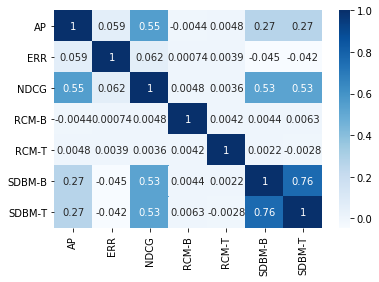

In [18]:
import pandas as pd
import seaborn as sns

absolute_matrix = np.copy(matrix)
for row in range(0,matrix.shape[0]):
    for col in range(0,3):
        if matrix[row][col] > 0:
            absolute_matrix[row][col] = 1
        if matrix[row][col] < 0:
            absolute_matrix[row][col] = 0
        else: #It is a draw, so we win in 50% of the cases and therefore set the value to 0.5
            absolute_matrix[row][col] = 0.5
%matplotlib inline
df = pd.DataFrame(absolute_matrix)
df_corr = df.corr()
ticklabels=["AP","ERR","NDCG","RCM-B","RCM-T","SDBM-B","SDBM-T"]
sns.heatmap(df_corr, annot=True,cmap="Blues",yticklabels=ticklabels,xticklabels=ticklabels)

In the heatmap above we see the correlation between all (both offline and online) evaluation methods based on all combinations. We did this by changing the offline evaluation methods based on the delta value for each metric. If the value was positive, so E outperformed P we made this value equal to 1. Whenever, the delta was negative, so P outperformed E, the value woul be set to zero. Finally, we then was a tie the value is set to 0.5. For the online evaluation metrics, we have the percentage of times E outperformed P from the N trials as value. 

There are several interesting things we notice. First of all, the random click model has a extremely low correlation. This is due to the fact that this model is totally random and therefore every iteration the outcome will have no correlation with the previous outcome. Secondly, we see that the highest correlation between an online and offline meausure is between SDBM-T and NDCG, where the correlation coefficient is equal to 0.53. The highest correlation between offline measures is between NDCG and the average precision and between online measures this is of course between the SDBM with the two different forms of interleaving. Finally, interestingly we see that the ERR has a very low correlation with all other metrics, which could indicate that in this setting this metric is less informative.

<b> Random click model <b>

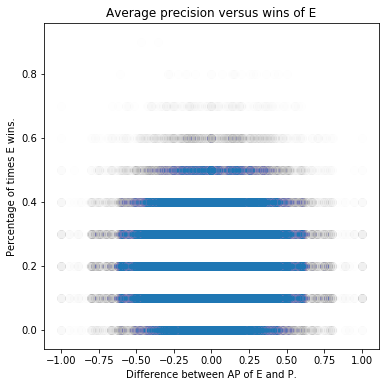

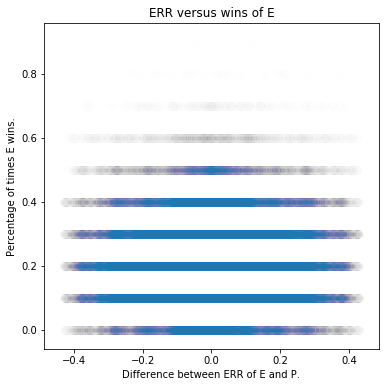

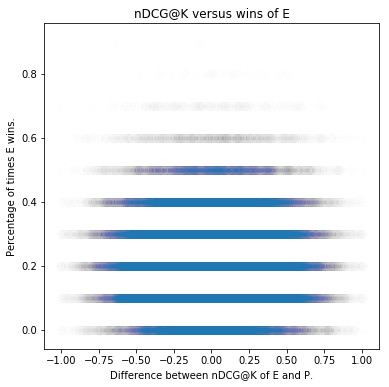

In [19]:
import matplotlib.pyplot as plt

#AP versus percentage wins RCM team draft interleaving
plt.figure(figsize=(6,6))
plt.scatter(matrix[:,0], matrix[:,3], s=70, alpha=0.003)
plt.xlabel('Difference between AP of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('Average precision versus wins of E')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(matrix[:,1], matrix[:,3], s=70, alpha=0.003)
plt.xlabel('Difference between ERR of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('ERR versus wins of E')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(matrix[:,2], matrix[:,3], s=70, alpha=0.003)
plt.xlabel('Difference between nDCG@K of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('nDCG@K versus wins of E')
plt.show()

For the random click model we can see that there is no correlation between offline scoring and online evaluation. This is in line with out expectations as the relevance of the documents is not considered when clicking a document, therefore winning of E is random. 

The spread in the plots is merely a result of a random process (the process of clicking and therefore winning of E) and difference in relevance scoring based on the relevancy of results.

<b>Simple Dynamic Bayesian Network<b>

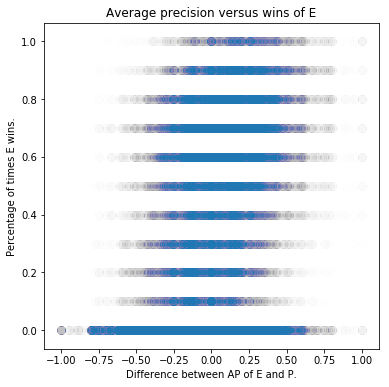

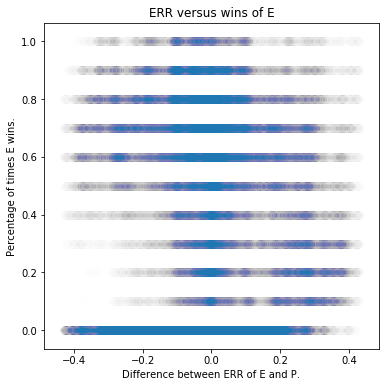

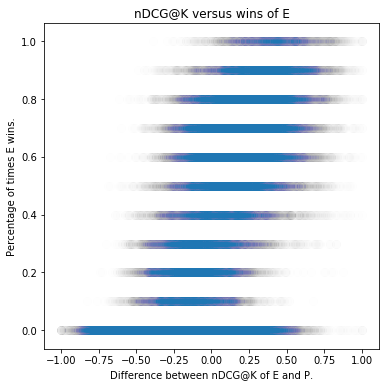

In [20]:
#AP versus percentage wins Simple Dynamic Bayesian Model team draft interleaving
plt.figure(figsize=(6,6))
plt.scatter(matrix[:,0], matrix[:,6], s=70, alpha=0.003)
plt.xlabel('Difference between AP of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('Average precision versus wins of E')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(matrix[:,1], matrix[:,6], s=70, alpha=0.003)
plt.xlabel('Difference between ERR of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('ERR versus wins of E')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(matrix[:,2], matrix[:,6], s=70, alpha=0.003)
plt.xlabel('Difference between nDCG@K of E and P.')
plt.ylabel('Percentage of times E wins.')
plt.title('nDCG@K versus wins of E')
plt.show()

From the correlation plots above, we could already tell that the ERR was uncorrelated with the online team draft interleaving. This means that this metric is a bad predictor for online performance.  

nDCG@K is the best indicator of online performance as it is highly correlated with percentage of wins for E (correlation of 0.52).

<b>Conclusion part 3) Statistical significance of results</b>

For Statistical Significance testing we want to see whether offline/online evaluation metrics agree on a certain algorithm being better. We use the Chi-Square to determine the statistical significance.

All the offline evaluations have a different order of magnitude, we normalize them to compare them. A value of 1 is used if they predict E is the winner, 0.5 is used for a tie, 0 for a win for P. 

In [21]:
from scipy import stats
from scipy.stats import chisquare
from collections import Counter
def chi_test(online):
    if online == True:
        ap_winner = []
        err_winner = []
        ndcg_winner = []
        #Here we compare the three offline evaluation metrics to check if they agree based on statistical significance.
        _,_,_,_,_,_,_,_,_,_,ap_total,err_total,ndcg_total = check_performance(combinations,False)
        assert (len(ap_total) == len(err_total) == len(ndcg_total))

        for item in ap_total:
            if item > 0:
                ap_winner.append(1)
            elif item < 0:
                ap_winner.append(0)
            else:
                ap_winner.append(0.5)

        for item in err_total:
            if item > 0:
                err_winner.append(1)
            elif item < 0:
                err_winner.append(0)
            else:
                err_winner.append(0.5)

        for item in ndcg_total:

            if item > 0:
                ndcg_winner.append(1)
            elif item < 0:
                ndcg_winner.append(0)
            else:
                ndcg_winner.append(0.5)

        chi_ap = [ap_winner.count(1),ap_winner.count(0.5),ap_winner.count(0)]
        chi_err = [err_winner.count(1),err_winner.count(0.5),err_winner.count(0)]
        chi_ndcg = [ndcg_winner.count(1),ndcg_winner.count(0.5),ndcg_winner.count(0)]
        
        print("Chi Square on AP and ERR:", chisquare(chi_ap,chi_err))
        print("Chi Square on AP and NDCG:", chisquare(chi_ap,chi_ndcg))
        print("Chi Square on NDCG and ERR:", chisquare(chi_ndcg,chi_err))
        
    else:
        chi_rcm1 = [list(matrix[:,3]).count(1),list(matrix[:,3]).count(0.5),list(matrix[:,3]).count(0)]
        chi_rcm2 = [list(matrix[:,4]).count(1),list(matrix[:,4]).count(0.5),list(matrix[:,4]).count(0)]
        for i in range(0,3):
            if chi_rcm1[i] == 0:
                chi_rcm1[i] = 1
            if chi_rcm2[i] == 0:
                chi_rcm2[i] = 1
        chi_sdbm1 = [list(matrix[:,5]).count(1),list(matrix[:,5]).count(0.5),list(matrix[:,5]).count(0)]
        chi_sdbm2 = [list(matrix[:,6]).count(1),list(matrix[:,6]).count(0.5),list(matrix[:,6]).count(0)]
        print("Chi Square on RCM with Balanced interleaving and Team Draft interleaving:", chisquare(chi_rcm1,chi_rcm2))
        print("Chi Square on RCM with Balanced interleaving and SDBM with balanced interleaving:", chisquare(chi_rcm1,chi_sdbm1))
        print("Chi Square on SDBM with Balanced interleaving and Team Draft interleaving:", chisquare(chi_sdbm1,chi_sdbm2))
        print("Chi Square on SDBM with Team Draft interleaving and RCM Team Draft interleaving:", chisquare(chi_rcm2,chi_sdbm2))
chi_test(True)

Chi Square on AP and ERR: Power_divergenceResult(statistic=414285.09892151196, pvalue=0.0)
Chi Square on AP and NDCG: Power_divergenceResult(statistic=149921.66911764705, pvalue=0.0)
Chi Square on NDCG and ERR: Power_divergenceResult(statistic=57.819664545980331, pvalue=2.7836803969399664e-13)


When evaluating the chi-square test one should look at the pvalue. A pvalue lower than 0.05 means that the two test are not from the same distribution, meaning that we can reject the $H_0$ hypothesis, which states that the two tests are from the same distribution. 

The results are in line with expectations, since all combinations are compared with each other and therefore we would expect the sum of all winner lists to be (approximately) the same and therefore their means will be the same for all offline evaluation methods. This shows that we cannot reject the null hypothesis that they have the same underlying distribution in all cases.

For the online methods, the results are comparable as they all respresent the wins of E. Therefore we can use them in the Chi-test directly.

In [22]:
chi_test(False)

Chi Square on RCM with Balanced interleaving and Team Draft interleaving: Power_divergenceResult(statistic=1.6244365429760104, pvalue=0.44387234396242847)
Chi Square on RCM with Balanced interleaving and SDBM with balanced interleaving: Power_divergenceResult(statistic=14885.474835866884, pvalue=0.0)
Chi Square on SDBM with Balanced interleaving and Team Draft interleaving: Power_divergenceResult(statistic=7.9005506746780441, pvalue=0.019249400966825179)
Chi Square on SDBM with Team Draft interleaving and RCM Team Draft interleaving: Power_divergenceResult(statistic=14798.09816976585, pvalue=0.0)


When comparing the online metrics we see that the difference between interleaving methods is not significant, so there the null hypothesis that these two samples are the same is not rejected. When comparing the different click models, we see that there the null hypothesis is rejected, so these are significantly different from each other.

In [23]:
#Bootstrap test
import scipy as sp
import scipy.stats
import random
def get_confidence_interval(data):#this function calculates a 95% confidence interval
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+0.95)/2., n-1)
    return m, m-h, m+h

def bootstrap(option): #this functions does the bootstrap test for 3 options. 
    # first is calculates the actual mean and confidence intervals 
    # Then it samples from the combinations and calculates what ratio of the cases it is ouside the confidence interval
    random.shuffle(combinations)
    diff_array = []
    num_samples = 50000
    out_of_bounds = 0
    _,_,_,_,_,_,_,_,_,_,ap_total,err_total,ndcg_total = check_performance(combinations,False)
    ap_total_flat = ap_total
    err_total_flat = err_total
    ndcg_total_flat = ndcg_total

    assert (len(ap_total_flat) == len(err_total_flat) == len(ndcg_total_flat)) # check

    ap_winner = []
    err_winner = []
    ndcg_winner = []

    for item in ap_total_flat:
        if item > 0:
            ap_winner.append(1)
        elif item < 0:
            ap_winner.append(0)
        else:
            ap_winner.append(0.5)

    for item in err_total_flat:
        if item > 0:
            err_winner.append(1)
        elif item < 0:
            err_winner.append(0)
        else:
            err_winner.append(0.5)

    for item in ndcg_total_flat:

        if item > 0:
            ndcg_winner.append(1)
        elif item < 0:
            ndcg_winner.append(0)
        else:
            ndcg_winner.append(0.5)
            
    if option == 1:
        actual_diff = [x1 - x2 for (x1, x2) in zip(ndcg_winner, err_winner)]
        actual_mean,lower,higher = get_confidence_interval(actual_diff)
    if option == 2:
        actual_diff = [x1 - x2 for (x1, x2) in zip(ap_winner, err_winner)]
        actual_mean,lower,higher = get_confidence_interval(actual_diff)
    if option == 3:
        actual_diff = [x1 - x2 for (x1, x2) in zip(ndcg_winner, err_winner)]
        actual_mean,lower,higher = get_confidence_interval(actual_diff)
    
    # From here on it starts taking samples. It takes "num_samples" of size 2
    for i in range(0,num_samples):
        ap_total = []
        err_total = []
        ndcg_total = []
        ap = []
        err = []
        ndcg = []
        a = np.random.randint(0,len(combinations)-1)
        combinations_check = combinations[a:a+1]
        _,_,_,_,_,_,_,_,_,_,ap_total,err_total,ndcg_total = check_performance(combinations_check,False)
        
        assert (len(ap_total) == len(err_total) == len(ndcg_total))

        ap_winner = []
        err_winner = []
        ndcg_winner = []

        for item in ap_total:
            if item > 0:
                ap_winner.append(1)
            elif item < 0:
                ap_winner.append(0)
            else:
                ap_winner.append(0.5)

        for item in err_total:
            if item > 0:
                err_winner.append(1)
            elif item < 0:
                err_winner.append(0)
            else:
                err_winner.append(0.5)

        for item in ndcg_total:
            if item > 0:
                ndcg_winner.append(1)
            elif item < 0:
                ndcg_winner.append(0)
            else:
                ndcg_winner.append(0.5)
        
        if option == 1:
            diff = np.mean(ndcg_winner) - np.mean(err_winner)
            diff_array.append(diff)
        if option == 2:
            diff = np.mean(ap_winner) - np.mean(err_winner)
            diff_array.append(diff)
        if option == 3:
            diff = np.mean(ap_winner) - np.mean(ndcg_winner)
            diff_array.append(diff)

    for element in diff_array: # check if it is inside our outside the confidence interval
        if np.mean(element) < lower or np.mean(element) > higher:
            out_of_bounds += 1
    
    return out_of_bounds/len(diff_array)
            
    
print("Percentage of differences between NDCG and ERR outside of 95 percent confidence interval: ",bootstrap(1)) # option 1 compares the NDCG with ERR method
print("Percentage of differences between AP and ERR outside of 95 percent confidence interval: ",bootstrap(2)) # option 2 compares the AP with ERR method
print("Percentage of differences between NDCG and AP outside of 95 percent confidence interval: ",bootstrap(3)) # option 3 compares the AP with NDCG method

Percentage of differences between NDCG and ERR outside of 95 percent confidence interval:  0.46844
Percentage of differences between AP and ERR outside of 95 percent confidence interval:  0.4966
Percentage of differences between NDCG and AP outside of 95 percent confidence interval:  0.24852


From the bootstrap test we see that in 25 to 49 percent of the cases the difference is outside the 95% confidence interval. We think this is due to the fact that we take random samples and therefore we will get a more significant result than in the Chi-Square test, since these results indicate a insignificant difference between the offline evaluation metrics.

<b>Conclusion part 4) Differences in interleaving methods<b>

Although the assignment only asks for one interleaving method, we've implemented both team based and balanced interleaving. We see no clear difference in the number of times E outperforms P for both interleaving methods. This is the case since every element in the two lists that are to be interleaved is unique. Both methods produce an interleaved list that contains the same "documents", where the chance of the last document coming from E or P is 50% for both interleaving methods. Over a large number of experiments this effect of randomness does not produce significant results, in accordance to the law of large numbers.

<b>Conclusion part 5) Differences in click models<b>

We see a clear difference between the random click model and the simplified dynamic Bayesian model. When the random click model is used, we have a large number of ties caused by the large number of queries without clicks (which is explained before); therefore only in around 22% of the cases does either E outperform P or vice versa. With the SDBM the probability of a tie is less than 1%, this is because 65% of the queries has one click, and 34% of the queries does not have a click, leaving little room for a query with 2 clicks, resulting in a tie. This means that a (simulated) user is very easily satisfied after opening a document. 


The drawback of random click model seems to be that only 49% of the queries a document is clicked as every document has the same click probability. This rho parameter is an average over all positions, however in reality the first documents should have a much higher click probability. The SDBM is more complicated and is able to simulate clicks more realisticly: as a user examines the list from top to bottom, the first documents have a higher probability of being clicked.